In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications import MobileNetV2
# from keras.applications import EfficientNetB0
# from keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import os
import numpy as np

2025-08-28 11:44:15.424046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756381455.631225      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756381455.691618      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
conv_base = DenseNet201(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

I0000 00:00:1756381468.900701      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9,
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [4]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 0.2
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6  # Minimum learning rate
)

In [5]:
# Define data augmentation
data_augmentation = keras.Sequential([
    # layers.RandomZoom(0.2),
    # layers.RandomTranslation(0.2, 0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomBrightness(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.3),
])


In [6]:
# Load dataset from input/fold
dataset_path = "/kaggle/input/refined-model-data/dataset_1/preprocessed_original_images/"
# dataset_path = "/kaggle/input/refined-model-data/dataset_2/"
img_height = 224
img_width = 224
batch_size = 20

dataset = keras.utils.image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 847 files belonging to 6 classes.


In [7]:
# Split dataset into train (80%) and test (20%)
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Further split train_dataset into train (80%) and validation (20%)
val_size = int(0.2 * train_size)
train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

In [8]:
# Function to apply augmentation and normalization to training data
def process_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    image = data_augmentation(image)            # Apply augmentation
    return image, label

# Function to normalize validation and test data
def process_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

In [9]:
# Apply processing functions
train_dataset = train_dataset.map(process_train, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(process_val, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [10]:
# # Load VGG16 base model
# conv_base = keras.applications.VGG16(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(224, 224, 3))

In [11]:
# # Unfreeze top 30 layers
for layer in conv_base.layers[-20:]:
    layer.trainable = True

In [12]:
# Define model-building function for Keras Tuner
def build_model(hp):
    # inputs = keras.Input(shape=(224, 224, 3))
    # x = data_augmentation(inputs)
    # x = conv_base(x, training=False)
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(256, activation='relu')(x)
    # x = layers.Dropout(0.3)(x)
    # outputs = layers.Dense(6, activation='softmax')(x)
    # model = keras.Model(inputs, outputs)
    # model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    #     loss='sparse_categorical_crossentropy',
    #     metrics=['accuracy']
    # )

    
    model = keras.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6, activation='softmax'))  # 4 classes
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [13]:
# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir_DenseNet201',
    project_name='DenseNet201_classification_data_1'
)
# Search for best hyperparameters
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    # class_weight=class_weightsx
)

Trial 5 Complete [00h 07m 25s]
val_accuracy: 0.4333333373069763

Best val_accuracy So Far: 0.824999988079071
Total elapsed time: 00h 37m 14s


In [14]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Create output directory
output_dir = 'DenseNet201/'
os.makedirs(output_dir, exist_ok=True)

Best units: 512
Best learning rate: 0.0001589535354940041


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1214 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Save the best model and weights
best_model.save(os.path.join(output_dir, 'best_model.keras'))
best_model.save_weights(os.path.join(output_dir, 'best_model_weights.weights.h5'))

# Define callbacks for further training
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(output_dir, 'best_finetuned_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)


In [16]:
# Further train the best model
history = best_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    # class_weight=class_weights,
    # callbacks=[checkpoint]
)



Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 400s 889ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.7500 - val_loss: 0.7217
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9624 - loss: 0.1065 - val_accuracy: 0.7083 - val_loss: 1.7223
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9783 - loss: 0.0654 - val_accuracy: 0.7333 - val_loss: 1.0560
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9830 - loss: 0.0535 - val_accuracy: 0.8000 - val_loss: 0.7494
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9744 - loss: 0.0716 - val_accuracy: 0.8083 - val_loss: 0.6613
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9883 - loss: 0.0405 - val_accuracy: 0.8167 - val_loss: 0.8402
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9904 - loss: 0.0266 - val_accuracy: 0.7750 - val_loss: 1.1507
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.9869 - loss: 0.0282 - val_ac

In [17]:
# Evaluate the model on test dataset
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8905 - loss: 0.6324
Test Loss: 0.7962
Test Accuracy: 0.8683


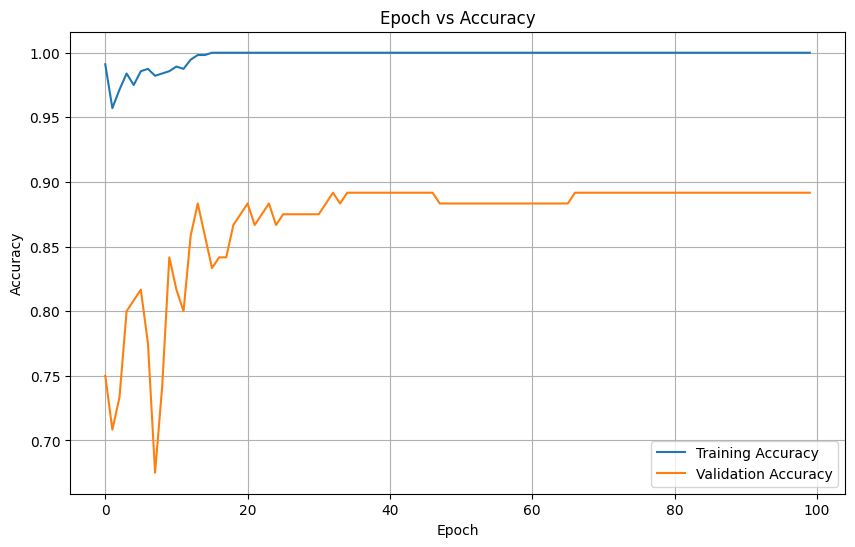

In [18]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
# plt.savefig('/kaggle/working/resnet/accuracy_plot.png')
plt.show()

In [19]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,467,732 (219.22 MB)

 Trainable params: 19,079,558 (72.78 MB)

 Non-trainable params: 229,056 (894.75 KB)

 Optimizer params: 38,159,118 (145.57 MB)

In [20]:
dataset.class_names

['chickenpox', 'cowpox', 'healthy', 'measles', 'monkeypox', 'smallpox']

In [21]:
# --- Evaluation Metrics ---
# Collect true labels and predictions from the test dataset
from sklearn.metrics import classification_report

y_true = []
y_pred = []
y_pred_proba = []
class_names=dataset.class_names

for images, labels in test_dataset.unbatch():
    y_true.append(labels.numpy())
    predictions = best_model.predict(images[None, ...], verbose=0)
    y_pred.append(np.argmax(predictions, axis=1)[0])
    y_pred_proba.append(predictions[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

  chickenpox       0.69      0.87      0.77        23
      cowpox       0.70      0.88      0.78         8
     healthy       1.00      1.00      1.00         9
     measles       1.00      0.50      0.67        10
   monkeypox       0.96      0.75      0.84        32
    smallpox       0.90      0.94      0.92        85

    accuracy                           0.87       167
   macro avg       0.87      0.82      0.83       167
weighted avg       0.88      0.87      0.87       167



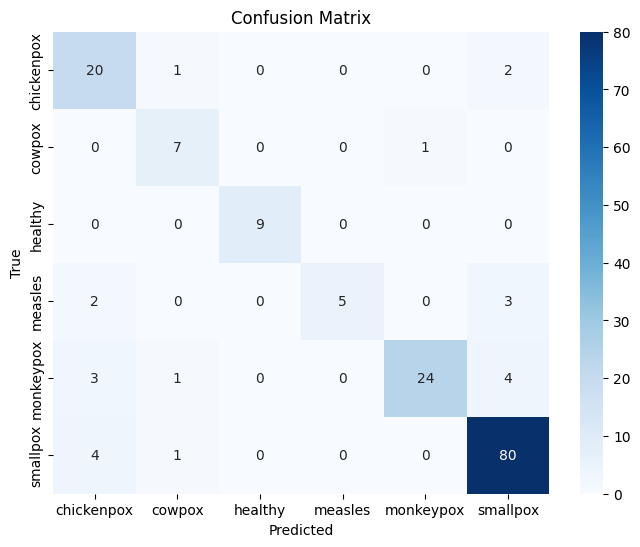

In [22]:
# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

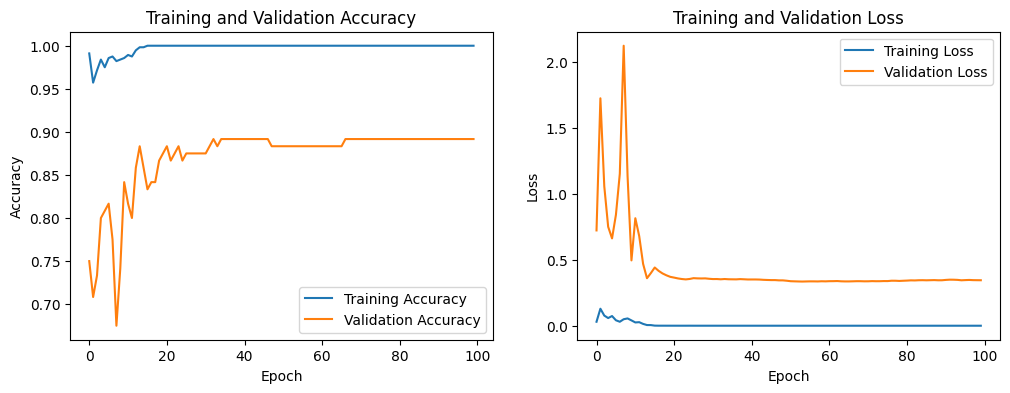

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

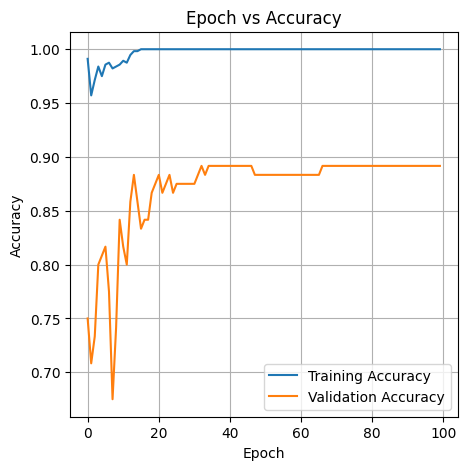

In [24]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/kaggle/working/DenseNet201/accuracy_plot.png')
plt.show()

In [ ]:
# import collections

# def calculate_dense_block_channels(initial_input_channels, num_layers_in_block, growth_rate):
#     """
#     Calculates the output channels for each internal layer of a dense block
#     and the final output of the block.
#     """
#     layer_details = []
#     current_channels_at_input_to_layer = initial_input_channels

#     for i in range(num_layers_in_block):
#         # Within each dense layer: BN -> ReLU -> Conv(1x1) -> BN -> ReLU -> Conv(3x3)
#         # The 1x1 Conv (bottleneck) typically expands to 4 * growth_rate
#         # The 3x3 Conv produces 'growth_rate' new feature maps.

#         # The input to the 3x3 conv is the output of the 1x1 conv
#         # The input to the 1x1 conv is the concatenation of all previous feature maps in the block
        
#         # Output of the 3x3 conv is 'growth_rate' features.
#         # These are concatenated to the input of the current layer for the *next* layer's input.
        
#         output_of_3x3_conv = growth_rate
        
#         layer_details.append({
#             f"Layer {i+1}": {
#                 "Input_Channels_to_Layer": current_channels_at_input_to_layer,
#                 "Operations": "BN -> ReLU -> Conv(1x1, Bottleneck) -> BN -> ReLU -> Conv(3x3)",
#                 "Output_Features_from_3x3": output_of_3x3_conv,
#                 "Channels_After_Concatenation": current_channels_at_input_to_layer + output_of_3x3_conv
#             }
#         })
#         current_channels_at_input_to_layer += output_of_3x3_conv # Channels grow for the next layer in the block
    
#     return layer_details, current_channels_at_input_to_layer # Total channels at block output


# def get_densenet201_architecture_details():
#     """
#     Provides structured details for DenseNet-201 architecture for diagramming.
#     """
#     architecture_info = collections.OrderedDict()

#     initial_input_size = (224, 224, 3) # H, W, C
#     growth_rate = 32
#     compression_factor = 0.5 # Theta for Transition Layers
    
#     # DenseNet-201 specific layer counts for each block
#     # Source: Usually derived from torchvision's implementation or official papers
#     # Typically: (6, 12, 48, 32)
#     dense_block_layer_counts = [6, 12, 48, 32]

#     # --- Initial Layers ---
#     current_channels = 3
#     architecture_info["Input"] = {
#         "Type": "Input Image",
#         "Size": initial_input_size
#     }

#     # Initial Convolution (7x7, stride 2) -> BatchNorm -> ReLU -> MaxPool (3x3, stride 2)
#     # Output channels typically 64 for DenseNet
#     output_initial_conv_channels = 64
#     architecture_info["Initial_Conv_Pool"] = {
#         "Type": "Convolution Block",
#         "Operations": "Conv(7x7, s=2) -> BN -> ReLU -> MaxPool(3x3, s=2)",
#         "Input_Channels": current_channels,
#         "Output_Channels": output_initial_conv_channels,
#         "Spatial_Reduction": "224x224 -> 112x112 (Conv) -> 56x56 (MaxPool)"
#     }
#     current_channels = output_initial_conv_channels
#     current_spatial_size = (56, 56) # After initial conv and maxpool

#     # --- Dense Blocks and Transition Layers ---
#     for i, num_layers in enumerate(dense_block_layer_counts):
#         block_id = i + 1
#         block_key = f"Dense_Block_{block_id}"
        
#         block_details, channels_after_block = calculate_dense_block_channels(
#             current_channels, num_layers, growth_rate
#         )
        
#         architecture_info[block_key] = {
#             "Type": "Dense Block",
#             "Layers_Count": num_layers,
#             "Growth_Rate": growth_rate,
#             "Input_Channels_to_Block": current_channels,
#             "Output_Channels_from_Block": channels_after_block,
#             "Spatial_Size": current_spatial_size,
#             "Internal_Layers_Details": block_details # This is the detailed breakdown
#         }
#         current_channels = channels_after_block

#         # Add Transition Layer if not the last Dense Block
#         if i < len(dense_block_layer_counts) - 1:
#             transition_key = f"Transition_Layer_{block_id}"
#             output_trans_channels = int(current_channels * compression_factor)
#             architecture_info[transition_key] = {
#                 "Type": "Transition Layer",
#                 "Operations": f"BN -> Conv(1x1) -> AvgPool(2x2)",
#                 "Compression_Factor": compression_factor,
#                 "Input_Channels": current_channels,
#                 "Output_Channels": output_trans_channels,
#                 "Spatial_Reduction": f"{current_spatial_size[0]}x{current_spatial_size[1]} -> {current_spatial_size[0]//2}x{current_spatial_size[1]//2}"
#             }
#             current_channels = output_trans_channels
#             current_spatial_size = (current_spatial_size[0]//2, current_spatial_size[1]//2)

#     # --- Final Layers ---
#     architecture_info["Global_Average_Pooling"] = {
#         "Type": "Pooling Layer",
#         "Operations": "Global Average Pooling",
#         "Input_Channels": current_channels,
#         "Output_Channels": current_channels, # Channels remain the same, spatial reduces to 1x1
#         "Spatial_Reduction": f"{current_spatial_size[0]}x{current_spatial_size[1]} -> 1x1"
#     }

#     num_classes = 1000 # Example for ImageNet
#     architecture_info["Fully_Connected_Softmax"] = {
#         "Type": "Classification Head",
#         "Operations": f"Fully Connected ({num_classes} units) -> Softmax",
#         "Input_Features": current_channels,
#         "Output_Probabilities": num_classes
#     }

#     architecture_info["Output"] = {
#         "Type": "Predicted Probabilities",
#         "Size": num_classes
#     }
    
#     return architecture_info

# # --- Generate the details and print them for your diagram ---
# densenet_details = get_densenet201_architecture_details()

# print("--- DenseNet-201 Architecture Details for Diagram ---")
# for key, value in densenet_details.items():
#     print(f"\n--- {key.replace('_', ' ')} ---")
#     for sub_key, sub_value in value.items():
#         if sub_key == "Internal_Layers_Details":
#             print(f"  {sub_key}:")
#             for layer_detail in sub_value:
#                 for layer_name, details in layer_detail.items():
#                     print(f"    - {layer_name}:")
#                     for det_key, det_value in details.items():
#                         print(f"      {det_key}: {det_value}")
#         else:
#             print(f"  {sub_key}: {sub_value}")